
[시계열 분해와 패턴 시각화]에 대한 상세 강의 자료와 실습 노트북이다.

이 시간의 핵심은 복잡해 보이는 시계열 데이터를 '추세(Trend)', '계절성(Seasonality)', '나머지(Residual)'라는 세 가지 재료로 분리해내는 것이다. 이를 통해 "환자가 늘어난 것이 계절 때문인가, 아니면 정말로 우리 병원이 성장하고 있는 것인가?"를 구분할 수 있다.

---

# 📘 시계열의 해부: 분해(Decomposition)

## 1. 시계열 분해란?
우리가 보는 데이터(예: 응급실 일일 내원객 수)는 사실 여러 가지 힘이 합쳐진 결과물이다. 시계열 분해는 이 합쳐진 힘들을 따로따로 떼어내어 분석하는 기법이다. 마치 "오케스트라 음악에서 바이올린, 첼로, 피아노 소리를 분리해서 듣는 것"과 같다.

## 2. 시계열의 3대 요소 (Components)
데이터는 보통 다음 세 가지의 합(또는 곱)으로 이루어진다.

1.  추세 (Trend):
    *   데이터가 장기적으로 나아가는 방향이다.
    *   *헬스케어 예시:* 고령화로 인한 만성질환 환자 수의 지속적인 증가.
2.  계절성 (Seasonality):
    *   일정한 기간(주기)을 두고 반복되는 패턴이다.
    *   *헬스케어 예시:*
        *   연간 패턴: 독감 환자는 매년 겨울(12~2월)에 급증한다.
        *   주간 패턴: 외래 환자는 보통 월요일에 가장 많고 금요일에 적다.
        *   일간 패턴: 응급실은 야간이나 새벽에 특정 환자군이 몰린다.
3.  잔차 / 불규칙 (Residual / Noise):
    *   추세와 계절성으로 설명되지 않는 나머지 부분이다. 예측 불가능한 사건이나 측정 오류가 여기에 해당한다.
    *   *헬스케어 예시:* 메르스나 코로나19 같은 갑작스러운 팬데믹 발발.

## 3. 분해 모델: 덧셈 vs 곱셈
*   가법 모델 (Additive): $데이터 = 추세 + 계절성 + 잔차$
    *   계절성 패턴의 진폭(높낮이)이 시간이 지나도 일정할 때 사용한다.
*   승법 모델 (Multiplicative): $데이터 = 추세 \times 계절성 \times 잔차$
    *   환자 수가 증가함에 따라 계절적 변동 폭도 같이 커질 때 사용한다. (대부분의 성장하는 데이터는 여기에 속한다.)

---
---

# 💻환자 수 데이터 분해하고 패턴 찾기

이 노트북에서는 `statsmodels` 라이브러리를 사용하여 시계열 분해를 실습한다. 가상의 '호흡기 내과 외래 환자 수' 데이터를 생성하여 겨울철 유행 패턴과 장기적인 환자 증가 추세를 분리해본다.

### 1. 환경 설정 및 데이터 생성
5년치(60개월) 월별 환자 데이터를 생성한다.



데이터 미리보기:


/tmp/ipython-input-3463100425.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=60, freq='M')


,Patients
2020-01-31,119.967142
2020-02-29,126.632017
2020-03-31,140.544682
2020-04-30,147.312756
2020-05-31,120.794059


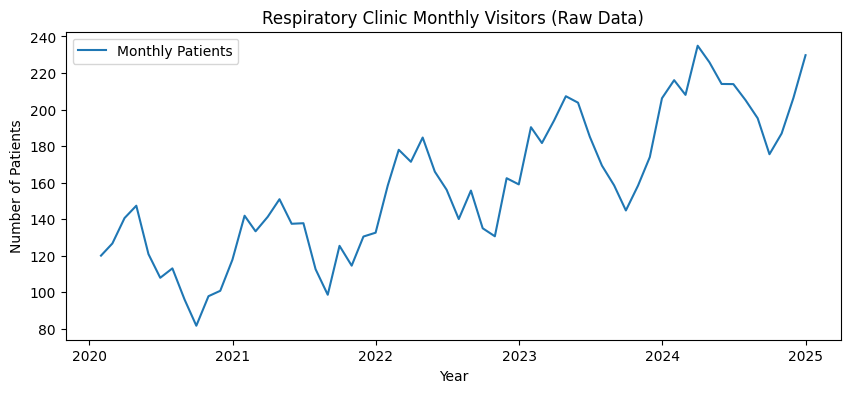

In [1]:
# statsmodels 설치 확인 (없을 경우 설치)
!pip install statsmodels pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. 날짜 인덱스 생성 (2020년 ~ 2024년, 월별)
dates = pd.date_range(start='2020-01-01', periods=60, freq='M')

# 2. 구성 요소 생성
np.random.seed(42)
# (1) 추세(Trend): 병원 인지도가 올라가며 환자가 매달 조금씩 증가 (Base 100명 + 월 2명씩 증가)
trend = np.linspace(100, 220, 60)

# (2) 계절성(Seasonality): 겨울(12,1,2월)에 높고 여름에 낮은 패턴 (주기 12개월)
# sin 함수를 이용해 주기적인 파동 생성
seasonality = 30 * np.sin(2 * np.pi * dates.month / 12)
# 겨울 위치를 맞추기 위한 위상 조정은 생략하고 단순 파동으로 가정 (여기선 시각적 이해가 목적)

# (3) 잔차(Residual): 랜덤한 변동 (+- 10명)
noise = np.random.normal(0, 10, 60)

# 3. 최종 데이터 결합 (Additive Model: 다 더하기)
# 겨울철 호흡기 환자 데이터 완성
data = trend + seasonality + noise

# 데이터프레임 생성
df = pd.DataFrame({'Patients': data}, index=dates)

print("데이터 미리보기:")
display(df.head())

# 원본 데이터 시각화
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Patients'], label='Monthly Patients')
plt.title("Respiratory Clinic Monthly Visitors (Raw Data)")
plt.xlabel("Year")
plt.ylabel("Number of Patients")
plt.legend()
plt.show()

# 해석: 울퉁불퉁하게 증가하는 모습이다. 어디까지가 계절 탓이고 어디까지가 성장세인지 눈으로는 정확히 알기 어렵다.

### 2. 시계열 분해 (Decomposition) 수행
`seasonal_decompose` 함수 한 줄이면 분석이 끝난다.

In [2]:
# 시계열 분해 수행
# model='additive': 덧셈 모델 사용 (데이터 = 추세 + 계절성 + 잔차)
# period=12: 데이터가 월별 데이터이므로 주기를 12로 설정
result = seasonal_decompose(df['Patients'], model='additive', period=12)

# 분해 결과는 result 객체 안에 trend, seasonal, resid로 각각 저장된다.
print("분해 완료.")

분해 완료.


### 3. 분해 결과 시각화
4개의 그래프(원본, 추세, 계절성, 잔차)를 한 번에 그려서 구조를 파악한다.

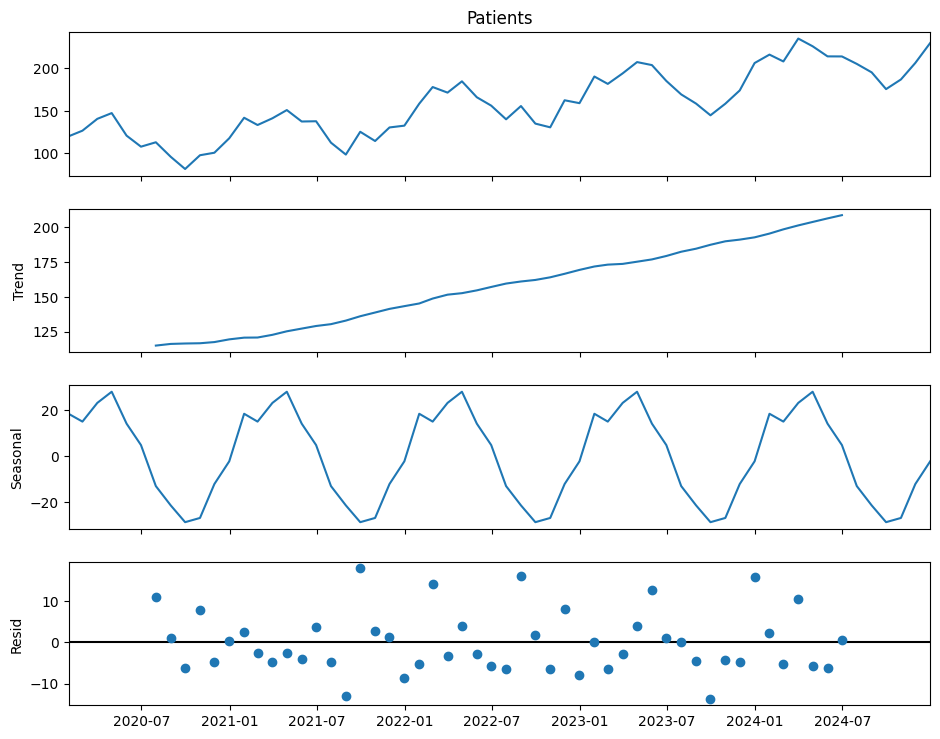

In [3]:
# statsmodels 내장 플롯 기능 사용
fig = result.plot()
fig.set_size_inches(10, 8) # 그래프 크기 키우기
plt.show()

# 해석:
# 1. Observed (맨 위): 원본 데이터.
# 2. Trend (두 번째): 계절성을 걷어내니 깔끔하게 우상향하는 직선이 보인다. (병원이 잘 성장하고 있다.)
# 3. Seasonal (세 번째): 매년 반복되는 파도 모양 패턴이 명확히 분리되었다.
# 4. Resid (맨 아래): 패턴으로 설명되지 않는 잡음들이다.

### 4. 계절성 패턴 상세 분석 (Heatmap)
"그래서 정확히 몇 월에 환자가 제일 많은가?"를 파악하기 위해 데이터를 `월(Month)` vs `연도(Year)`의 표(Pivot Table)로 재구성하고 히트맵을 그린다.

연도별/월별 환자 수 (Pivot Table):


Year,2020,2021,2022,2023,2024
Month,,,,,
1,120.0,142.0,158.0,190.0,216.0
2,127.0,133.0,178.0,182.0,208.0
3,141.0,141.0,171.0,194.0,235.0
4,147.0,151.0,185.0,207.0,226.0
5,121.0,137.0,166.0,204.0,214.0
6,108.0,138.0,156.0,185.0,214.0
7,113.0,113.0,140.0,169.0,205.0
8,96.0,99.0,156.0,158.0,195.0
9,82.0,125.0,135.0,145.0,176.0


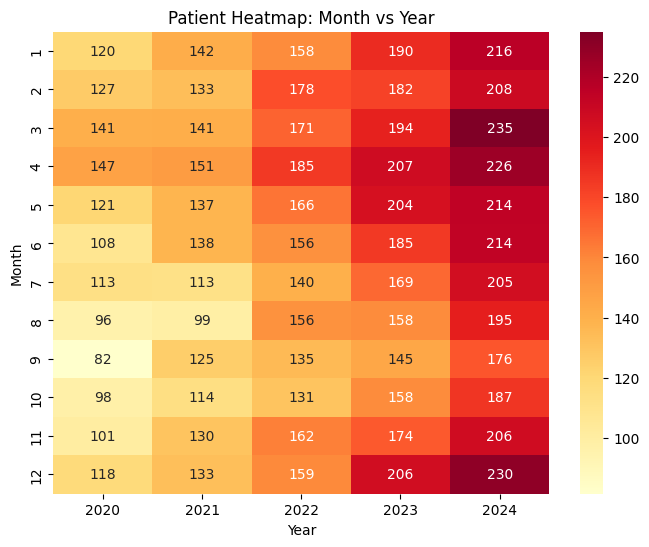

In [4]:
# 1. 연도와 월 컬럼 추출
df['Year'] = df.index.year
df['Month'] = df.index.month

# 2. 피벗 테이블 생성 (행: 월, 열: 연도, 값: 환자수)
pivot_df = df.pivot_table(values='Patients', index='Month', columns='Year')

print("연도별/월별 환자 수 (Pivot Table):")
display(pivot_df.round(0))

# 3. 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, cmap='YlOrRd', annot=True, fmt='.0f') # 붉은색일수록 환자 많음
plt.title("Patient Heatmap: Month vs Year")
plt.xlabel("Year")
plt.ylabel("Month")
plt.show()

### 5. 계절성 플롯 (Seasonal Plot)
모든 연도의 월별 패턴을 겹쳐서 그린다. 매년 같은 패턴이 반복되는지 확인하는 가장 확실한 방법이다.

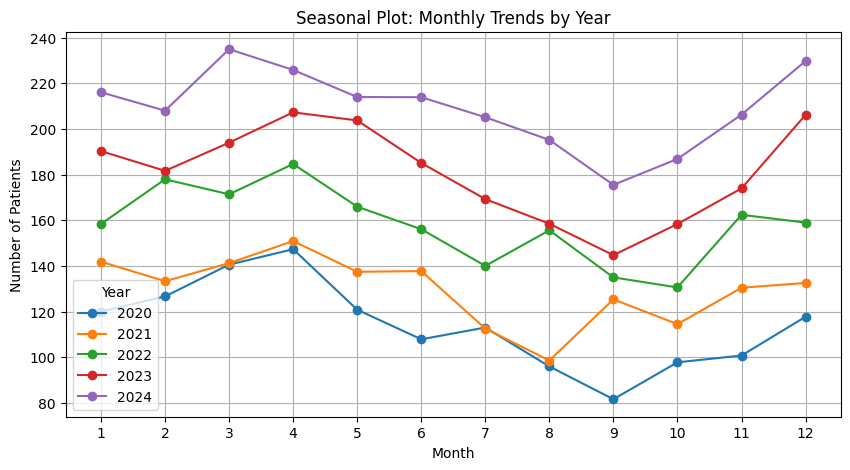

In [5]:
plt.figure(figsize=(10, 5))

# 연도별로 반복문을 돌며 그래프 그리기
for year in df['Year'].unique():
    subset = df[df['Year'] == year]
    plt.plot(subset['Month'], subset['Patients'], marker='o', label=str(year))

plt.title("Seasonal Plot: Monthly Trends by Year")
plt.xlabel("Month")
plt.ylabel("Number of Patients")
plt.xticks(range(1, 13)) # x축을 1월~12월로 고정
plt.legend(title="Year")
plt.grid(True)
plt.show()

# 해석: 모든 선들이 비슷한 모양(겨울에 높고 여름에 낮음)을 그리고 있다.
# 연도가 지날수록(색깔이 바뀔수록) 전체적인 높이가 올라가는 것은 'Trend' 때문이다.

### 📝 실습 과제
위의 `df` 데이터를 이용하여 다음을 분석해본다.

1.  잔차(Residual/Noise) 분석: `result.resid` 데이터를 이용하여 잔차의 분포(히스토그램)를 그려본다. 잔차는 0을 중심으로 정규분포를 띄는 것이 이상적이다.
2.  이상치 탐지: 잔차가 비정상적으로 컸던(예: 절대값 15 이상) 시점이 언제인지 찾아본다.

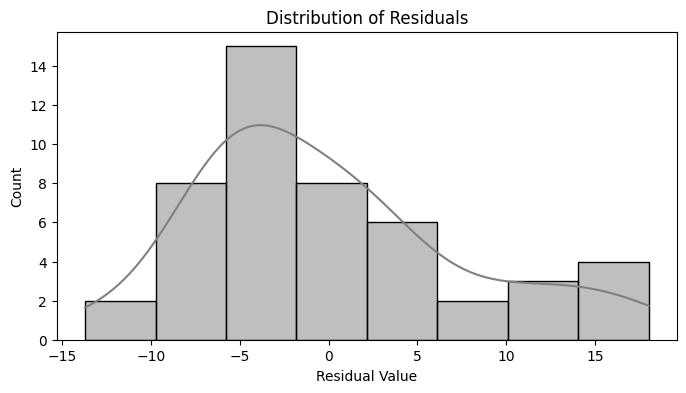

설명되지 않는 큰 변동이 있었던 시점:
2021-09-30    18.018981
2022-08-31    16.109615
2023-12-31    15.906309
Name: resid, dtype: float64


In [6]:
# [실습 답안 예시]

# 1. 잔차 데이터 추출 (앞뒤 6개월은 이동평균 계산으로 인해 NaN이 발생하므로 제거)
resid = result.resid.dropna()

# 히스토그램 그리기
plt.figure(figsize=(8, 4))
sns.histplot(resid, kde=True, color='gray')
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.show()

# 2. 이상치 시점 찾기
outliers = resid[abs(resid) > 15]
print("설명되지 않는 큰 변동이 있었던 시점:")
print(outliers)